### Import Libraries


In [1]:
import pathlib
import itertools
from joblib import load

import pandas as pd
from matplotlib import pyplot as plt


import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_confusion_matrix, get_SCM_model_data

### Load Datasets


In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)


### Evaluate Each Model on Each Dataset

#### Note: `cm` stands for confusion matrix in variable names


In [ ]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_cm_data = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # find confusion matrix for chosen model evaluated on chosen dataset
        cm_data = model_confusion_matrix(model, data, feature_type)
        plt.show()

        # add confusion matrix data to compiled dataframe in tidy format
        # use stack to restructure dataframe into tidy long format
        cm_data = cm_data.stack()
        # reset index must be used to make indexes at level 0 and 1 into individual columns
        # these columns correspond to true label and predicted label, and are set as indexes after using stack()
        cm_data = pd.DataFrame(cm_data).reset_index(level=[0, 1])
        cm_data.columns = ["True_Label", "Predicted_Label", "Count"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        cm_data["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        cm_data["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        cm_data["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_cm_data.append(cm_data)


### Save scores from each evaluation


In [ ]:
# compile list of tidy data into one dataframe
compiled_cm_data = pd.concat(compiled_cm_data).reset_index(drop=True)

# specify results directory
cm_data_dir = pathlib.Path("evaluations/confusion_matrices/")
cm_data_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_cm_data_save_path = pathlib.Path(f"{cm_data_dir}/compiled_cm_data.tsv")

# save data as tsv
compiled_cm_data.to_csv(compiled_cm_data_save_path, sep="\t")

# preview tidy data
compiled_cm_data


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


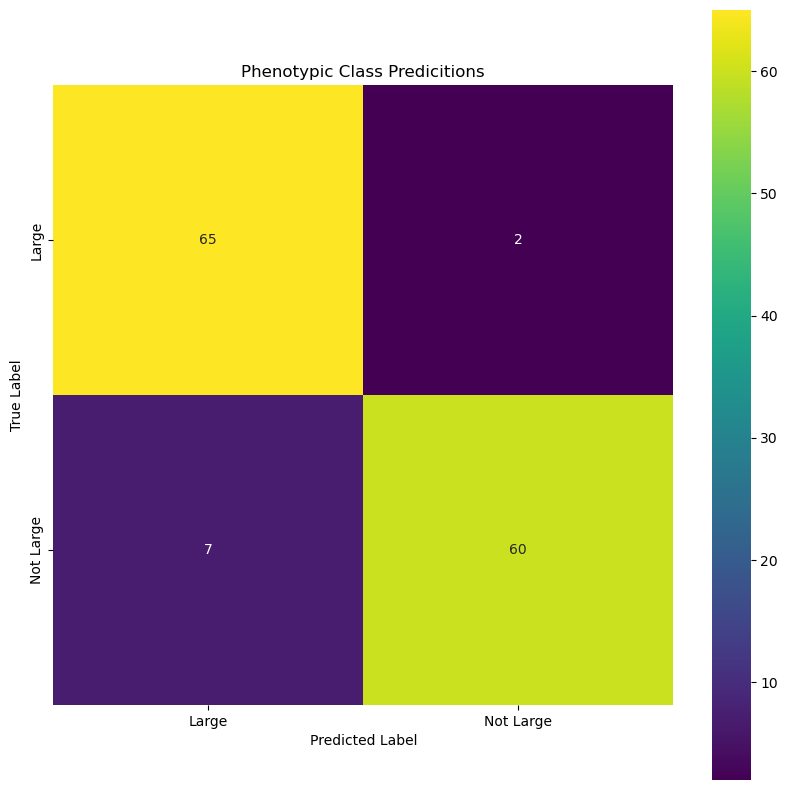

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/single_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_cm_data = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
evaluation_types = ["train", "test"]
phenotypic_classes = features_dataframe["Mitocheck_Phenotypic_Class"].unique()

# create a figure that has 6x5 subplots
# fig, axs = plt.subplots(6, 5)
# fig.set_size_inches(15, 18)

# iterate through each combination of feature_types, evaluation_types, phenotypic_classes
for model_type, feature_type, evaluation_type in itertools.product(
    model_types, feature_types, evaluation_types
):
    for phenotypic_class in phenotypic_classes:

        # load single class model for this combination of model type, feature type, and phenotypic class
        single_class_model_path = pathlib.Path(
            f"{models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)
        
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {evaluation_type}"
        )
        
        # load dataset (train, test, etc)
        single_cell_data = get_dataset(features_dataframe, data_split_indexes, evaluation_type)
        # rename negative labels and downsample negative lables if we are evaluating on training data
        single_cell_data = get_SCM_model_data(single_cell_data, phenotypic_class, evaluation_type)
        
        # find confusion matrix for chosen model evaluated on chosen dataset
        cm_data = model_confusion_matrix(single_class_model, single_cell_data, feature_type)
        plt.show()
        
        break
    break
